In [ ]:
!pip install python-graphblas[default]
!pip install metagraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from metagraph import concrete_algorithm, NodeID
from metagraph.plugins import has_grblas
from metagraph.plugins.core import exceptions
from typing import Tuple, Iterable, Any, Union, Optional


from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector, Scalar
from graphblas.io import mmread

In [ ]:
A = Matrix.from_coo(
    [0, 0, 1, 2, 2, 3, 4],
    [1, 2, 3, 3, 4, 4, 0],
    [1.1, 9.8, 4.2, 7.1, 0.2, 6.9, 2.2],
)
A

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix      7      5      5   FP64  bitmapr
----------------------------------------------
     0    1    2    3    4
0       1.1  9.8          
1                 4.2     
2                 7.1  0.2
3                      6.9
4  2.2

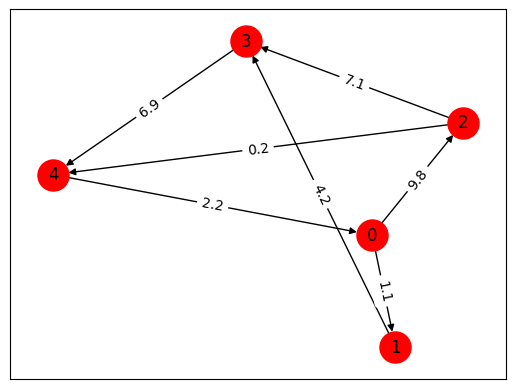

In [ ]:
gb.viz.draw(A)

In [ ]:
def pagerank_3f(A, d_out, damping=0.85, itermax=100, tol=1e-4):
    """
    Returns (result as Vector, iters as int)
    """
    n = A.nrows
    teleport = (1 - damping) / n
    rdiff = 1  # first iteration is always done

    # r = 1 / n
    t = Vector(dtypes.FP32, n)
    r = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)
    r[:] << 1.0 / n

    # prescale with damping factor, so it isn't done each iteration
    # d = d_out / damping
    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] << damping

    # --------------------------------------------------------------------------
    # pagerank iterations
    # --------------------------------------------------------------------------
    for i in range(itermax):
        if rdiff <= tol:
            break

        # swap t and r ; now t is the old score
        r, t = t, r

        # w = t ./ d
        w << t.ewise_mult(d, binary.truediv)

        # r = teleport
        r[:] << teleport

        # r += A'*w
        r(binary.plus) << A.T.mxv(w, semiring.plus_second)

        # t -= r
        t(binary.minus)[:] << r

        # t = abs (t)
        t << t.apply(unary.abs)

        # rdiff = sum (t)
        rdiff = t.reduce(monoid.plus).value

    return r, i

In [ ]:
A

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix      7      5      5   FP64  bitmapr
----------------------------------------------
     0    1    2    3    4
0       1.1  9.8          
1                 4.2     
2                 7.1  0.2
3                      6.9
4  2.2

In [ ]:
# Pagerank requires binary input graph
A << A.apply(unary.one)
A

"M_0"      nvals  nrows  ncols  dtype         format
gb.Matrix      7      5      5   FP64  bitmapr (iso)
----------------------------------------------------
     0    1    2    3    4
0       1.0  1.0          
1                 1.0     
2                 1.0  1.0
3                      1.0
4  1.0

In [ ]:
# Compute outbound degree of nodes
d_out = A.reduce_rowwise(monoid.plus).new()
d_out

"v_0"      nvals  size  dtype  format
gb.Vector      5     5   FP64    full
-------------------------------------
index    0    1    2    3    4
value  2.0  1.0  2.0  1.0  1.0

In [ ]:
result, iters = pagerank_3f(A, d_out)

In [ ]:
result

"v_13"     nvals  size  dtype  format
gb.Vector      5     5   FP32    full
-------------------------------------
index         0         1         2         3         4
value  0.254212  0.138031  0.138031  0.205973  0.263752

In [ ]:
iters

37

Другое кольцо

In [50]:
import graphblas as gb
from graphblas import Matrix, Vector, binary, semiring, unary, monoid, dtypes

def pagerank_plus_times_NEW(A, d_out, damping=0.85, itermax=100, tol=1e-4):
    """
    Returns (result as Vector, iters as int)
    """
    n = A.nrows
    teleport = (1 - damping) / n
    rdiff = 1  # first iteration is always done

    # Initialize vectors
    t = Vector(dtypes.FP32, n)
    r = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)
    r[:] = 1.0 / n

    # Prescale with damping factor, so it isn't done each iteration
    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] = damping

    # --------------------------------------------------------------------------
    # pagerank iterations
    # --------------------------------------------------------------------------
    for i in range(itermax):
        if rdiff <= tol:
            break

        # swap t and r ; now t is the old score
        r, t = t, r

        # w = t ./ d
        w << t.ewise_mult(d, binary.truediv)

        # r = teleport
        r[:] = teleport

        # r += A' * w using plus_times semiring
        r(binary.plus) << A.T.mxv(w, semiring.plus_times)

        # t -= r
        t(binary.minus)[:] = r

        # t = abs(t)
        t << t.apply(unary.abs)

        # rdiff = sum(t)
        rdiff = t.reduce(monoid.plus).value

    return r, i


In [51]:
result1, iters1 = pagerank_plus_times_NEW(A, d_out)
result1

"v_730"    nvals  size  dtype  format
gb.Vector      5     5   FP32    full
-------------------------------------
index         0         1         2         3         4
value  0.254212  0.138031  0.138031  0.205973  0.263752

Ещё один вариант

In [ ]:
import graphblas as gb
from graphblas import Vector, Matrix, dtypes, binary, unary, monoid, semiring

def pagerank_algebraic(A, d_out, damping=0.85, itermax=100, tol=1e-4):

    n = A.nrows
    teleport = (1 - damping) / n
    rdiff = 1  # first iteration is always done

    # Initialize vectors
    r = Vector(dtypes.FP32, n)
    r[:] = 1.0 / n
    t = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)

    # Prescale with damping factor
    d = d_out.dup(dtype=dtypes.FP32)
    d(binary.times)[:] = damping

    for i in range(itermax):
        if rdiff <= tol:
            break

        # Swap t and r; now t is the old score
        r, t = t, r

        # w = t ./ d
        w(binary.truediv)[:] = t.ewise_mult(d, binary.truediv)

        # r = teleport
        r[:] = teleport

        # r += A' * w using a different semiring
        r(binary.plus)[:] = A.T.mxv(w, semiring.plus_times)

        # t -= r
        t(binary.minus)[:] = r

        # t = abs(t)
        t.apply(unary.abs)

        # rdiff = sum(t)
        rdiff = t.reduce(monoid.plus).value

    return r, i

r, iterations = pagerank_algebraic(A, d_out)
r

"v_291"    nvals  size  dtype  format
gb.Vector      5     5   FP32    full
-------------------------------------
index         0         1         2         3         4
value  0.265294  0.147647  0.147647  0.382941  0.382941

### Compare with networkx for accuracy

In [52]:
import networkx as nx

g = gb.io.to_networkx(A)
g.edges()

OutEdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4), (4, 0)])

In [53]:
nx.pagerank(g, tol=1e-4)

{0: 0.2542370526098617,
 1: 0.13807850431853438,
 2: 0.13807850431853438,
 3: 0.2059371902920227,
 4: 0.2636687484610469}

### Compare with networkx for speed

Need a larger graph for this test

In [41]:
big = nx.erdos_renyi_graph(1000, 0.04, directed=True)

In [42]:
%%timeit
pr = nx.pagerank(big, tol=1e-6)

35.3 ms ± 905 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
B = gb.io.from_networkx(big, dtype="UINT8")
B

"M_4"      nvals  nrows  ncols  dtype     format
gb.Matrix  39961   1000   1000  UINT8  csr (iso)
------------------------------------------------
    0   1   2   3   4   5   6   7   8   9    ... 990 991 992 993 994 995 996  \
0                                            ...                               
1                                            ...                               
2         1                                  ...                               
3                                            ...   1   1                       
4                                            ...           1                   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
995                                          ...                               
996                                          ...                               
997                                          ...                               
998                               1          ...                               
999                                          ...                               

    997 998 999  
0     1          
1                
2                
3                
4     1          
..   ..  ..  ..  
995              
996              
997              
998              
999

In [44]:
%%timeit
bd_out = B.reduce_rowwise(monoid.plus).new()
results, iter = pagerank_3f(B, bd_out, tol=1e-6)

31.3 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
# timeit doesn't save variables, so recompute
pr = nx.pagerank(big, tol=1e-6)
bd_out = B.reduce_rowwise(monoid.plus).new()
results, iter = pagerank_3f(B, bd_out, tol=1e-6)

In [ ]:
iter

7

In [ ]:
# Only look at first 10 results from networkx
{k: v for k, v in pr.items() if k < 10}

{0: 0.0009289892362295132,
 1: 0.0008815110128540986,
 2: 0.0010349796154918447,
 3: 0.000878183337853016,
 4: 0.0011028315315945705,
 5: 0.0010246587492484503,
 6: 0.0011130191158820943,
 7: 0.001070690259898533,
 8: 0.0010898157695906315,
 9: 0.0008442121620818434}

In [ ]:
# Verify all results match
all(abs(results[i].value - pr[i]) < 1e-5 for i in range(1000))

True

In [40]:
M1 = mmread('/content/Erdos02.mtx')
M2 = mmread('/content/Erdos972.mtx')
M3 = mmread('/content/Erdos982.mtx')

In [85]:
import graphblas as gb
from graphblas import Vector, Matrix, dtypes, binary, unary, monoid, semiring
import networkx as nx

def pagerank(A,alpha=0.85, personalization=None, max_iter=100, tol=1e-4, nstart=None, weight='weight', dangling=None):
    #d = d_out.dup(dtype="FP32")
    n = A.nrows
    teleport = (1 - alpha) / n
    rdiff = 1  # first iteration is always done

    if personalization is None:
        personalization = {i: 1/n for i in range(n)}
    p = Vector.from_dict(personalization, size=n, dtype=dtypes.FP32)
    p(binary.times)[:] = 1.0 / sum(personalization.values())

    # Handle dangling nodes
    if dangling is None:
        dangling_weights = {i: 1.0/n for i in range(n)}
    else:
        dangling_weights = {i: dangling.get(i, 0) for i in range(n)}
    dangle_sum = sum(dangling_weights.values())
    dangling_vec = Vector.from_dict(dangling_weights, size=n, dtype=dtypes.FP32)
    dangling_vec(binary.times)[:] = 1.0 / dangle_sum

    # Initial pagerank vector
    r = Vector(dtypes.FP32, n)
    if nstart is None:
        r[:] = 1.0 / n
    else:
        r.update(Vector.from_dict(nstart, size=n, dtype=dtypes.FP32))
    t = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)

    # Out-degree vector
    d_out = A.reduce_rowwise(monoid.plus).new(dtype=dtypes.FP32)
    d = d_out.dup()
    d(binary.times)[:] = alpha

    for i in range(max_iter):
        if rdiff <= tol:
            break

        # Swap t and r; now t is the old score
        r, t = t, r

        # w = t ./ d
        w(binary.truediv)[:] = t.ewise_mult(d, binary.truediv)

        # r = teleport * personalization + alpha * (A' * w + dangling_vec)
        r[:] = teleport * p
        r(binary.plus)[:] = A.T.mxv(w, semiring.plus_times)
        r(binary.plus)[:] = alpha * (r + dangling_vec)

        # t -= r
        t(binary.minus)[:] = r

        # t = abs(t)
        t.apply(unary.abs)

        # rdiff = sum(t)
        rdiff = t.reduce(monoid.plus).value

    return r, i

# Example usage
# G: NetworkX graph
r, iterations = pagerank(M1,alpha=0.85, max_iter=100, tol=1e-4)
r

"v_1040"   nvals  size  dtype  format
gb.Vector   6927  6927   FP32    full
-------------------------------------
index      0        1         2         3         4         5         6     \
value  0.003003  0.00735  0.001275  0.005983  0.003867  0.004985  0.000752   

index      7         8         9     ...      6917      6918      6919  \
value  0.002517  0.001491  0.001669  ...  0.000194  0.000157  0.000135   

index      6920      6921      6922      6923      6924      6925      6926  
value  0.000138  0.000168  0.000154  0.000151  0.000144  0.000149  0.019448

In [98]:
%%timeit
g1 = gb.io.to_networkx(M1)
g1.edges()
nx.pagerank(g1, alpha=0.85, max_iter=100, tol=1e-4)

74.1 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
nstart = {0: 0.5, 1: 0.5, 2: 0.5}

personalization = {0: 0.4, 1: 0.4, 2: 0.2}

dangling = {0: 0.5, 1: 0.3, 2: 0.2}

In [102]:

%%timeit
r, iterations = pagerank(M2, alpha=0.85, personalization=personalization, max_iter=100, tol=1e-4, nstart=nstart, weight=None, dangling=dangling)
r

6.3 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
g2 = gb.io.to_networkx(M2)

In [101]:
%%timeit
nx.pagerank(g2, alpha=0.85, personalization=personalization, max_iter=100, tol=1e-4, nstart=nstart, weight=None, dangling=dangling)

45 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
%%timeit
r3, i3=pagerank(M3,tol=1e-5)
r3

4.95 ms ± 99.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
%%timeit
g3 = gb.io.to_networkx(M3)
g3.edges()
nx.pagerank(g3,tol=1e-5)

The slowest run took 4.23 times longer than the fastest. This could mean that an intermediate result is being cached.
93 ms ± 57.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
%%timeit
results, iter = pagerank(M1, tol=1e-6)


6.55 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [92]:
%%timeit
pr = nx.pagerank(g, tol=1e-6)

4.83 ms ± 86.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
